In [ ]:
# are gardens all in a specific type of neighborhoods? e.g. rich/gentrified areas?

# side idea: use random forest/logistic regression for predicting
# whether a specific NTA would have a garden (note: not including crime)

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from matplotlib.pylab import plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [92]:
data = pd.read_csv('../data/ACS_Merged_renamed.csv', index_col=0) # 2012-2016
data.head()

,GeogName,GeoID,Population,MalePop,FemalePop,PopUnder18,PopOver65,MedianAge,PopHispanic,PopNotHisp,...,Edu9t12,EduHS,EduCollND,EduAssoc,EduBachelor,EduGradProf,EduLessHS,EduaboveBach,GardenCounts,HasGarden
0,Bath Beach,BK27,33163.0,16686.0,16477.0,7103.0,4888.0,38.3,5861.0,27302.0,...,2326.0,6188.0,2486.0,1667.0,5345.0,2664.0,5472.0,8009.0,0,0
1,Bay Ridge,BK31,79134.0,37829.0,41305.0,15110.0,12380.0,39.5,14134.0,65000.0,...,3900.0,11165.0,8251.0,3746.0,15823.0,11187.0,8006.0,27010.0,0,0
2,Bedford,BK75,75318.0,36491.0,38827.0,22379.0,5816.0,29.1,14682.0,60636.0,...,5791.0,11608.0,6838.0,2215.0,9148.0,5258.0,9699.0,14406.0,23,1
3,Bensonhurst East,BK29,64267.0,31283.0,32984.0,12773.0,10107.0,39.6,7923.0,56344.0,...,4700.0,12871.0,4433.0,3262.0,9412.0,4476.0,11556.0,13888.0,1,1
4,Bensonhurst West,BK28,91646.0,44651.0,46995.0,19288.0,13071.0,37.8,13378.0,78268.0,...,7191.0,18127.0,6748.0,4796.0,12275.0,4784.0,18286.0,17059.0,2,1


In [93]:
data.set_index('GeogName', inplace=True) 

In [94]:
data = data.drop(columns=['GeoID'])
data.head(2)

,Population,MalePop,FemalePop,PopUnder18,PopOver65,MedianAge,PopHispanic,PopNotHisp,PopWhite,PopBlack,...,Edu9t12,EduHS,EduCollND,EduAssoc,EduBachelor,EduGradProf,EduLessHS,EduaboveBach,GardenCounts,HasGarden
GeogName,,,,,,,,,,,,,,,,,,,,,
Bath Beach,33163.0,16686.0,16477.0,7103.0,4888.0,38.3,5861.0,27302.0,14490.0,404.0,...,2326.0,6188.0,2486.0,1667.0,5345.0,2664.0,5472.0,8009.0,0,0
Bay Ridge,79134.0,37829.0,41305.0,15110.0,12380.0,39.5,14134.0,65000.0,50197.0,1511.0,...,3900.0,11165.0,8251.0,3746.0,15823.0,11187.0,8006.0,27010.0,0,0


In [95]:
data.shape

(195, 39)

In [96]:
data.dropna(inplace=True)

In [174]:
data_x = data.iloc[:, :38]
data_x.head(2)

,Population,MalePop,FemalePop,PopUnder18,PopOver65,MedianAge,PopHispanic,PopNotHisp,PopWhite,PopBlack,...,EduBelow9,Edu9t12,EduHS,EduCollND,EduAssoc,EduBachelor,EduGradProf,EduLessHS,EduaboveBach,GardenCounts
GeogName,,,,,,,,,,,,,,,,,,,,,
Bath Beach,33163.0,16686.0,16477.0,7103.0,4888.0,38.3,5861.0,27302.0,14490.0,404.0,...,3146.0,2326.0,6188.0,2486.0,1667.0,5345.0,2664.0,5472.0,8009.0,0
Bay Ridge,79134.0,37829.0,41305.0,15110.0,12380.0,39.5,14134.0,65000.0,50197.0,1511.0,...,4106.0,3900.0,11165.0,8251.0,3746.0,15823.0,11187.0,8006.0,27010.0,0


In [102]:
data_garden_cts = data['GardenCounts']
data_has_garden = data['HasGarden']

In [175]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(data_x)
data_xscaled = scaler.transform(data_x)

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [176]:
from sklearn.decomposition import PCA
pca = PCA(data_x.shape[1])
pca_model = pca.fit_transform(data_xscaled) # exclude GardenCounts and HasGarden
pca.explained_variance_ratio_.cumsum()

array([0.47686879, 0.70608353, 0.7661704 , 0.81442507, 0.85541629,
       0.8803121 , 0.90253656, 0.92138573, 0.93706221, 0.94969627,
       0.96051554, 0.96876578, 0.97370826, 0.97816779, 0.98229662,
       0.98580593, 0.98794769, 0.98971344, 0.99140441, 0.99294207,
       0.9942451 , 0.99534302, 0.99623486, 0.99705175, 0.99773115,
       0.99838516, 0.9988246 , 0.99923528, 0.99954226, 0.99977226,
       0.99990936, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])

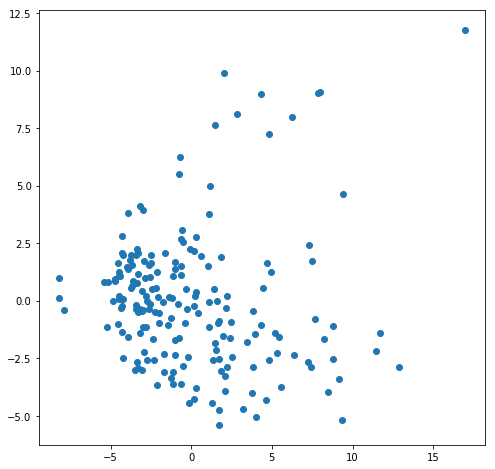

In [179]:
#2-d plot
fig = plt.figure(figsize=(8,8))

plt.scatter(x=pca_model[:, 0], y=pca_model[:, 1])

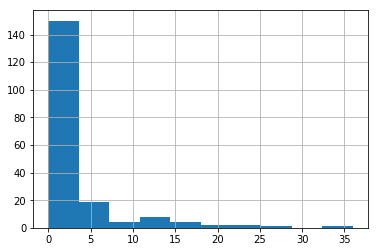

In [164]:
data_garden_cts.hist() # Number of gardens per NTA

In [173]:
# scaler_garden_cts = preprocessing.StandardScaler().fit(data_garden_cts)
# scaler_garden_cts.transform(data_garden_cts)

preprocessing.StandardScaler?